In [1]:
!pip install efficientnet
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from efficientnet.keras import EfficientNetB5
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.4 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Set the path to the dataset
data_path = '/kaggle/input/garbage-classification/garbage_classification'

def load_images(path, target_shape):
    X = []
    y = []
    for folder in os.listdir(path):
        if os.path.isdir(os.path.join(path, folder)):
            folder_path = os.path.join(path, folder)
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                image = cv2.imread(image_path)
                resized_image = cv2.resize(image, target_shape[:2])
                X.append(resized_image)
                y.append(folder)
    X = np.array(X)
    y = np.array(y)
    return X, y

# Set the target shape for input images
target_shape = (80, 80, 3)

# Load and preprocess the data
X, y = load_images(data_path, target_shape)
num_classes = len(np.unique(y))
y = to_categorical(LabelEncoder().fit_transform(y))

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    

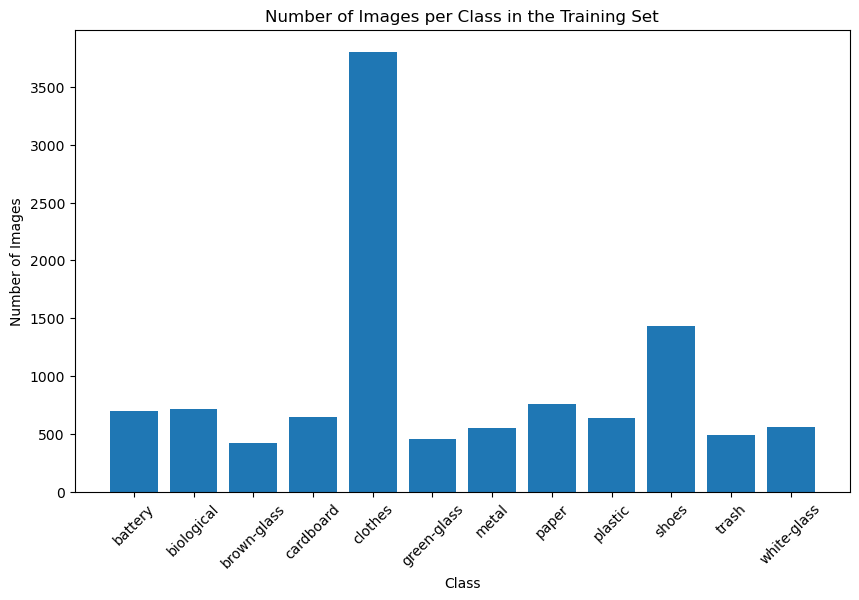

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Count the number of images for each class in the training set
class_counts = np.sum(y_train, axis=0)

# Get the class names
class_names = sorted(os.listdir(data_path))

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in the Training Set')
plt.xticks(rotation=45)
plt.show()


In [4]:
# Count the number of images for each class in the training set
class_counts = np.sum(y_train, axis=0)

# Get the class names
class_names = sorted(os.listdir(data_path))

# Print the number of images for each class
for class_name, count in zip(class_names, class_counts):
    print(f"Class: {class_name}, Number of Images: {count}")


Class: battery, Number of Images: 697.0
Class: biological, Number of Images: 715.0
Class: brown-glass, Number of Images: 421.0
Class: cardboard, Number of Images: 647.0
Class: clothes, Number of Images: 3804.0
Class: green-glass, Number of Images: 459.0
Class: metal, Number of Images: 552.0
Class: paper, Number of Images: 757.0
Class: plastic, Number of Images: 639.0
Class: shoes, Number of Images: 1429.0
Class: trash, Number of Images: 489.0
Class: white-glass, Number of Images: 561.0


In [5]:




# Calculate the class counts in the original training set
class_counts = np.sum(y_train, axis=0)

# Define the maximum number of images per class
desired_num_images = 2500

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an instance of the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Lists to store the augmented data
augmented_X_train = []
augmented_y_train = []

# Iterate over each class
for class_index, count in enumerate(class_counts):
    if count < desired_num_images:
        # Calculate the number of additional images needed
        num_augmented_images = int(desired_num_images - count)

        # Get the indices of samples for the current class
        indices = np.where(y_train[:, class_index] == 1)[0]

        # Randomly select images with replacement
        selected_indices = np.random.choice(indices, size=num_augmented_images, replace=True)
        selected_images = X_train[selected_indices]

        # Generate augmented images
        for image in selected_images:
            # Reshape the image for augmentation
            augmented_image = image.reshape((1,) + image.shape)

            # Generate augmented images and labels
            for X_aug, y_aug in datagen.flow(augmented_image, [y_train[selected_indices[0]]], batch_size=1):
                augmented_X_train.append(X_aug[0])
                augmented_y_train.append(y_aug[0])
                break

# Convert the augmented data into numpy arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

# Reshape augmented_X_train to match the shape of X_train
augmented_X_train = augmented_X_train.reshape(-1, *target_shape)

# Reshape augmented_y_train to match the shape of y_train
augmented_y_train = augmented_y_train.reshape(-1, num_classes)

# Concatenate the original and augmented data
X_train = np.concatenate((X_train, augmented_X_train), axis=0)
y_train = np.concatenate((y_train, augmented_y_train), axis=0)

# Verify the new class counts in the augmented training set
augmented_class_counts = np.sum(y_train, axis=0)

# Define the label encoder
le = LabelEncoder()
le.fit(y_train.argmax(axis=1))

# Print the class counts after augmentation
for class_index, count in enumerate(augmented_class_counts):
    class_label = le.inverse_transform([class_index])[0]
    print(f"Class: {class_label}, Number of Images: {count}")



Class: 0, Number of Images: 2500.0
Class: 1, Number of Images: 2500.0
Class: 2, Number of Images: 2500.0
Class: 3, Number of Images: 2500.0
Class: 4, Number of Images: 3804.0
Class: 5, Number of Images: 2500.0
Class: 6, Number of Images: 2500.0
Class: 7, Number of Images: 2500.0
Class: 8, Number of Images: 2500.0
Class: 9, Number of Images: 2500.0
Class: 10, Number of Images: 2500.0
Class: 11, Number of Images: 2500.0


In [6]:
# Construct the EfficientNetB5 model
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=target_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(num_classes, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

115515256/115515256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 2048)             28513520  
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                       

In [7]:
import tensorflow as tf

class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.batches == 0 and epoch > 0:
            tr_acc = logs.get('accuracy')
            v_loss = logs.get('val_loss')

            if tr_acc > self.highest_tracc:
                self.highest_tracc = tr_acc

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                self.best_weights = self.model.get_weights()
                self.count = 0
            else:
                self.count += 1

            if tr_acc >= self.threshold:
                self.ask_epoch -= 1

            if self.count == self.patience and self.ask_epoch > 0:
                print("\nEpoch %d: Accuracy threshold reached. Decreasing learning rate." % (epoch + 1))
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                print("Learning rate decreased from %f to %f" % (old_lr, new_lr))
                self.count = 0

            if self.count == self.patience and self.ask_epoch == 0:
                self.stop_count += 1
                if self.stop_count == self.stop_patience:
                    print("\nTraining stopped at epoch %d" % (epoch + 1))
                    self.model.stop_training = True
                else:
                    print("\nEpoch %d: Learning rate adjustment limit reached. Restoring best weights." % (epoch + 1))
                    self.model.set_weights(self.best_weights)
                    self.count = 0

In [8]:
# Define the callbacks
checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
my_callback = MyCallback(model=model, patience=10, stop_patience=5, threshold=0.9, factor=0.1, batches=10, epochs=100, ask_epoch=10)

# Train the model
history = model.fit(X_train, y_train, batch_size=8, epochs=15, validation_data=(X_val, y_val), callbacks=[checkpoint, my_callback])

# Load the best weights
model.load_weights('/kaggle/working/best_model.h5')

Epoch 1/15


2023-07-13 12:13:36.032972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3913/3913 [==============================] - ETA: 0s - loss: 3.7651 - accuracy: 0.6714
Epoch 1: val_accuracy improved from -inf to 0.89614, saving model to /kaggle/working/best_model.h5
3913/3913 [==============================] - 404s 78ms/step - loss: 3.7651 - accuracy: 0.6714 - val_loss: 1.0452 - val_accuracy: 0.8961
Epoch 2/15
3913/3913 [==============================] - ETA: 0s - loss: 1.0181 - accuracy: 0.8347
Epoch 2: val_accuracy improved from 0.89614 to 0.89936, saving model to /kaggle/working/best_model.h5
3913/3913 [==============================] - 301s 77ms/step - loss: 1.0181 - accuracy: 0.8347 - val_loss: 0.7360 - val_accuracy: 0.8994
Epoch 3/15
3913/3913 [==============================] - ETA: 0s - loss: 0.7147 - accuracy: 0.8944
Epoch 3: val_accuracy improved from 0.89936 to 0.93478, saving model to /kaggle/working/best_model.h5
3913/3913 [==============================] - 302s 77ms/step - loss: 0.7147 - accuracy: 0.8944 - val_loss: 0.5662 - val_accuracy: 0.9348
Epoch 

In [9]:
# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Convert integer labels to class names
class_names = sorted(os.listdir(data_path))
y_true_names = np.array(class_names)[y_true_labels]
y_pred_names = np.array(class_names)[y_pred_labels]

# Generate and print the classification report
report = classification_report(y_true_names, y_pred_names)
print("Classification Report:")
print(report)


97/97 [==============================] - 8s 38ms/step
Classification Report:
              precision    recall  f1-score   support

     battery       0.88      0.96      0.92       188
  biological       0.96      0.90      0.93       196
 brown-glass       0.93      0.87      0.90       135
   cardboard       0.95      0.93      0.94       186
     clothes       0.99      0.98      0.99      1076
 green-glass       0.90      0.92      0.91       119
       metal       0.86      0.90      0.88       159
       paper       0.89      0.97      0.92       204
     plastic       0.85      0.79      0.82       157
       shoes       0.92      0.94      0.93       394
       trash       0.96      0.95      0.95       142
 white-glass       0.91      0.86      0.89       147

    accuracy                           0.94      3103
   macro avg       0.92      0.92      0.91      3103
weighted avg       0.94      0.94      0.94      3103



In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)






97/97 [==============================] - 4s 38ms/step - loss: 0.4366 - accuracy: 0.9378
Test loss: 0.43664878606796265
Test accuracy: 0.9378021359443665
